In [2]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "graduate_admission1.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "safaruzzamanshovo/graduate-admission-dataset",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())
print("Dataset columns:", df.columns)

/tmp/ipython-input-3985887345.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'graduate-admission-dataset' dataset.
First 5 records:    GRE Score  TOEFL Score  University Rating  SOP  LOR    GPA  Research  \
0        295           96                  2  4.9   1.7  2.93         0   
1        340          119                  3  4.1   1.7  3.76         0   
2        336           96                  1  3.2   1.8  3.12         1   
3        337          108                  4  3.4   1.3  2.11         0   
4        323           98                  1  1.1   1.3  3.40         0   

   Chance of Admit  
0            0.612  
1            0.708  
2            0.728  
3            0.643  
4            0.524  
Dataset columns: Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'GPA',
       'Research', 'Chance of Admit'],
      dtype='object')


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [4]:
# Define features (X) and target (y)
features = ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'GPA', 'Research']
X = df[features]
y = df['Chance of Admit']

In [6]:
# --- 2. Standardization and Splitting ---

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the features and transform the data (standardization)
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features) # Convert back to DataFrame for better inspection

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Dataset size: {len(df)} samples")
print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")
print("\n--- Standardized Data Sample (First 5 Rows) ---")
print(X_scaled.head())
print("-" * 40)

Dataset size: 1000 samples
Training set size: 800 samples
Testing set size: 200 samples

--- Standardized Data Sample (First 5 Rows) ---
   GRE Score  TOEFL Score  University Rating       SOP      LOR        GPA  \
0  -1.382340    -1.238378          -0.741220  1.636768 -1.130614 -0.166803   
1   1.602559     1.484893          -0.037307  0.948689 -1.130614  1.258132   
2   1.337235    -1.238378          -1.445133  0.174600 -1.044596  0.159387   
3   1.403566     0.182459           0.666605  0.346620 -1.474684 -1.574571   
4   0.474931    -1.001571          -1.445133 -1.631608 -1.474684  0.640088   

   Research  
0 -1.034598  
1 -1.034598  
2  0.966559  
3 -1.034598  
4 -1.034598  
----------------------------------------


In [7]:
# --- 3. Model Training and Cross-Validation ---

# Initialize the Linear Regression model
model = LinearRegression()

# 3.1. Cross-Validation (CV)
# We use 5-fold cross-validation on the scaled training data.
# Scoring is done using 'neg_mean_squared_error' (Scikit-learn convention: always negative for errors)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert negative scores back to positive MSE and calculate the average
rmse_scores = np.sqrt(-cv_scores)
avg_rmse_cv = rmse_scores.mean()

print("\n--- Cross-Validation Results (5-Fold) ---")
print(f"Individual RMSE Scores (from CV): {rmse_scores.round(4)}")
print(f"Average Cross-Validated RMSE: {avg_rmse_cv:.4f} (Lower is better)")
print("-" * 40)

# 3.2. Final Model Training
# Train the model on the entire training set
model.fit(X_train, y_train)


--- Cross-Validation Results (5-Fold) ---
Individual RMSE Scores (from CV): [0.0296 0.0326 0.0288 0.0305 0.0313]
Average Cross-Validated RMSE: 0.0306 (Lower is better)
----------------------------------------


LinearRegression()

In [8]:
# --- 4. Prediction and Evaluation ---

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n--- Final Test Set Evaluation ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f} (Closer to 1.0 is better)")
print("-" * 40)

# Display coefficients (importance/direction of features)
print("\n--- Model Coefficients (Feature Importance) ---")
coefficients = pd.Series(model.coef_, index=features)
print(coefficients.sort_values(ascending=False).round(4))
print("-" * 40)

# Display predictions vs actual values for a few test samples
results = pd.DataFrame({'Actual Chance': y_test, 'Predicted Chance': y_pred.round(4)})
print("\n--- Prediction Sample vs Actual ---")
print(results.head())

# Post-processing: Ensure predictions are between 0 and 1
y_pred_clipped = np.clip(y_pred, 0, 1)

print("\nNote: For linear regression on probabilities (0-1), it is good practice")
print("to 'clip' the predictions to ensure they stay within the valid range [0, 1].")
print(f"First 5 Clipped Predictions: {y_pred_clipped[:5].round(4)}")


--- Final Test Set Evaluation ---
Mean Squared Error (MSE): 0.0008
Root Mean Squared Error (RMSE): 0.0289
R-squared (R²): 0.9028 (Closer to 1.0 is better)
----------------------------------------

--- Model Coefficients (Feature Importance) ---
Research             0.0763
University Rating    0.0292
GPA                  0.0279
LOR                  0.0242
SOP                  0.0224
TOEFL Score          0.0103
GRE Score            0.0083
dtype: float64
----------------------------------------

--- Prediction Sample vs Actual ---
     Actual Chance  Predicted Chance
521          0.760            0.7769
737          0.772            0.7830
740          0.895            0.8733
660          0.962            0.9186
411          0.676            0.6338

Note: For linear regression on probabilities (0-1), it is good practice
to 'clip' the predictions to ensure they stay within the valid range [0, 1].
First 5 Clipped Predictions: [0.7769 0.783  0.8733 0.9186 0.6338]


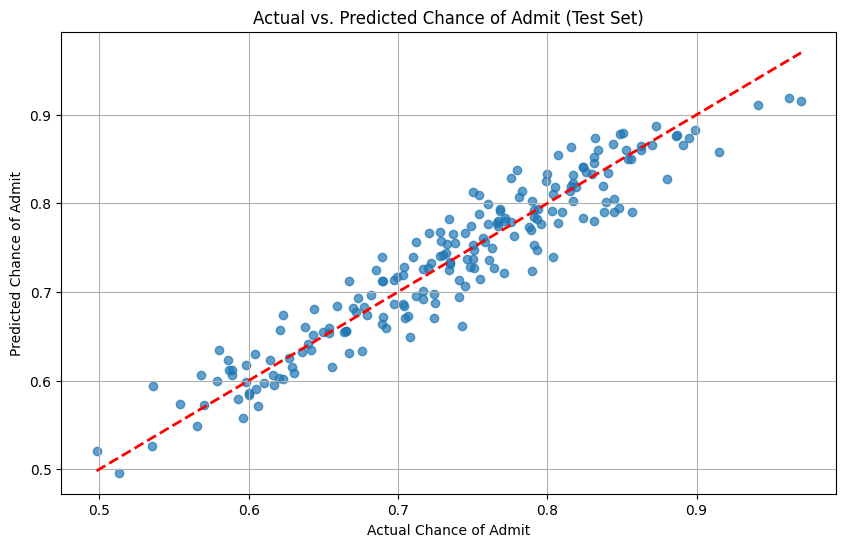

In [9]:
# --- 5. Visualization (Optional) ---
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs. Predicted Chance of Admit (Test Set)')
plt.xlabel('Actual Chance of Admit')
plt.ylabel('Predicted Chance of Admit')
plt.grid(True)
plt.show()